In [7]:
#Import things
import numpy as np
import matplotlib.pyplot as plt
import resampler as samp
import scipy.optimize as op
import chainconsumer as CC
import emcee #for doing MCMC
%matplotlib inline

In [8]:
#Plot formatting
plt.rc("font", size=18, family="serif")
plt.rc("text", usetex=True)

In [10]:
filename = "\\Users\\hugor\\OneDrive\\Escritorio\\chain.1.txt"
data = np.loadtxt(filename)
weights = data[:, 0]
lnpost = -data[:, 1]
hrdrag = data[:, 2]
Om = data[:, 3]
# Stack all the parameter columns
input_chain = np.column_stack((hrdrag, Om))

In [11]:
#Pick out training points
N_training = 1200
RS = samp.resampler(input_chain, lnpost, scale = 8)
RS.select_training_points(N_training, method="LH")
#Train the GP inside of the sampler
RS.train()

      fun: 8759.279912552529
 hess_inv: array([[2.35105559e-05]])
      jac: array([-108.13378906])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 68
      nit: 6
     njev: 55
   status: 2
  success: False
        x: array([-0.77875271])


In [12]:
# Extract the best starting point
start = input_chain[np.argmax(lnpost)]  # Best-fit parameters
nwalkers = 200
ndim = input_chain.shape[1]  # Ensure this is correctly set to 3
# Ensure sampler gets properly shaped input
def log_prob(params):
    params = np.atleast_2d(params)  # Ensure shape (N, ndim)
    return RS.predict(params)[0]  # Extract scalar log-likelihood
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
# Proper walker initialization
p0 = start + 1e-3 * np.random.randn(nwalkers, ndim)  # Ensure shape (nwalkers, ndim)
# Run MCMC
print("Running first burn-in")
p0, lp, _ = sampler.run_mcmc(p0, 1000, progress=True)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + 1e-4 * np.random.randn(nwalkers, ndim)  # Ensure correct shape
p0, lp, _ = sampler.run_mcmc(p0, 1500, progress=True)
# sampler.reset()
print("Running production...")
sampler.run_mcmc(p0, 5000, progress=True)

test_chain = sampler.flatchain

Running first burn-in


100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]


Running second burn-in


100%|██████████| 1500/1500 [15:00<00:00,  1.67it/s]


Running production...


100%|██████████| 5000/5000 [49:27<00:00,  1.68it/s]


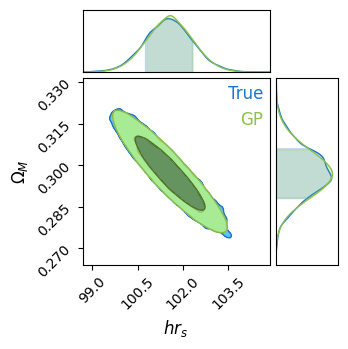

In [14]:
c2 = CC.ChainConsumer()

labels = [r"$hr_s$", r"$\Omega_M$"]
c2.add_chain(input_chain[:,:7], parameters=labels, name='True', weights=weights)
c2.add_chain(test_chain[:,:7], parameters=labels, name="GP")
c2.configure(legend_kwargs={"fontsize": 12})

fig = c2.plotter.plot()